# Imports

In [ ]:
%load_ext lab_black

import h5py
import os

from dataclasses import dataclass
from tqdm.auto import tqdm
from scipy.signal import savgol_filter
from scipy.interpolate import interp2d
from functools import lru_cache
import lmfit as lm

from typing import Dict, List, Optional, Tuple
import numpy as np
import plotly.graph_objects as go
import plotly.colors as pc
import matplotlib.pyplot as plt


import sys

sys.path.append(r"C:\Users\atully\Code\GitHub\ARPES Code\arpes-code-python")
from arpes_functions import (
    fitting_functions,
    analysis_functions,
    plotting_functions,
    HDF5_loader,
    misc_functions,
    filter_functions,
    tr_functions,
    loading_functions,
    cnn,
)

colors = pc.qualitative.D3
colors_seq = pc.sequential.dense
angstrom = "\u212B"
Theta = "\u0398"

# Load Data

In [ ]:
ddir = r"E:\atully\arpes_data\2023_February\6eV\TR"
files = ["TR11_Ali_avg.h5"]  # 1.7 eV center energy; -1 to 100 ps

ARPES_DATA: Dict[str, tr_functions.ArpesData] = {}
ARPES_ATTRS: Dict[str, tr_functions.ArpesAttrs] = {}
for file in tqdm(files):
    data, theta, phi_or_time, energy = loading_functions.load_hdf5(ddir, file)
    ARPES_DATA[file] = tr_functions.ArpesData(
        data=data, theta=theta, phi_or_time=phi_or_time, energy=energy
    )
    ARPES_ATTRS[file] = tr_functions.load_attrs_hdf5(ddir, file)

ad_11 = ARPES_DATA[files[0]]

In [ ]:
ddir = r"E:\atully\arpes_data\2023_February\6eV\TR"
files = ["TR3_Ali_avg.h5"]  # 2.15 eV center energy; -1 to 2 ps

ARPES_DATA: Dict[str, tr_functions.ArpesData] = {}
ARPES_ATTRS: Dict[str, tr_functions.ArpesAttrs] = {}
for file in tqdm(files):
    data, theta, phi_or_time, energy = loading_functions.load_hdf5(ddir, file)
    ARPES_DATA[file] = tr_functions.ArpesData(
        data=data, theta=theta, phi_or_time=phi_or_time, energy=energy
    )
    ARPES_ATTRS[file] = tr_functions.load_attrs_hdf5(ddir, file)

ad_3 = ARPES_DATA[files[0]]

In [ ]:
ddir = r"E:\atully\arpes_data\2023_February\6eV\TR"
files = [
    "TR4_Ali_avg.h5"
]  # 2.6 eV center energy; -1 to 1 ps, same number of steps as first 2 ps of TR3

ARPES_DATA: Dict[str, tr_functions.ArpesData] = {}
ARPES_ATTRS: Dict[str, tr_functions.ArpesAttrs] = {}
for file in tqdm(files):
    data, theta, phi_or_time, energy = loading_functions.load_hdf5(ddir, file)
    ARPES_DATA[file] = tr_functions.ArpesData(
        data=data, theta=theta, phi_or_time=phi_or_time, energy=energy
    )
    ARPES_ATTRS[file] = tr_functions.load_attrs_hdf5(ddir, file)

ad_4 = ARPES_DATA[files[0]]

In [ ]:
ad = ad_4

for k in ["energy", "theta", "phi_or_time"]:
    print(f"{k}.shape = {getattr(ad, k).shape}")
print(f"Data.shape = {ad.data.shape}")

In [ ]:
print(f"Delay range (mm): {np.min(ad.phi_or_time), np.max(ad.phi_or_time)}")
print(
    f"Energy range (eV): {np.round(np.min(ad.energy), 2), np.round(np.max(ad.energy), 2)}"
)
print(f"Theta range: {np.round(np.min(ad.theta), 1), np.round(np.max(ad.theta), 1)}")

# Build Composite Dataset

### Plan
ad_11 --> 1.7 eV center energy; -1 to 100 ps; 80 steps in delay (mm), but -1 to 1 ps in 21 steps (not great time resolution...)

ad_3 --> 2.15 eV center energy; -1 to 2 ps; 62 steps in delay (mm)

ad_4 --> 2.6 eV center energy; -1 to 1 ps; 42 steps in delay (mm)

1. cut down to same timescale (-1 to 1 ps --> 37.81 to 38.11 mm)
2. ensure appropriate x axis

In [ ]:
## Zero Delay ##

time_zero = 37.958  # from BiSe

## HOMO is at 2.05 eV below EF, based on fits from this data averaged with fits from tr-ARPES results ##

EF_400 = 1.91  # in kinetic energy, slit 400
EF_700 = 1.94  # in kinetic energy, slit 700

homo = -2.05

homo_400 = homo + EF_400
homo_700 = homo + EF_700

In [ ]:
## Integrate over desired angular range ##

slice_dim = "x"
slice_val = 0
int_range = 20  # if this value is more that the integration range, my get_2D_slice function will just integrate over the max range.

xlim = None
ylim = None
x_bin = 1
y_bin = 1

In [ ]:
all_vals = []
for ad in [ad_11, ad_3, ad_4]:
    all_vals.append(
        tr_functions.slice_datacube(
            ad_dataclass=ad,
            slice_dim=slice_dim,
            slice_val=slice_val,
            int_range=int_range,
            xlim=xlim,
            ylim=(
                ad.energy[57],
                ad.energy[1007],
            ),  # get rid of zero padding on datasets
            x_bin=x_bin,
            y_bin=y_bin,
            norm_data=False,
            plot_data=False,
        )
    )
x_11, y_11, d_11 = all_vals[0]
x_3, y_3, d_3 = all_vals[1]
x_4, y_4, d_4 = all_vals[2]

In [ ]:
## Plot Data: MPL ##

fig, ax = plt.subplots(1)

ax.pcolormesh(x_11, y_11, d_11, shading="auto", cmap="plasma", vmin=0, vmax=2.5)
ax.pcolormesh(x_3, y_3, d_3, shading="auto", cmap="plasma", vmin=0, vmax=0.2)
ax.pcolormesh(x_4, y_4, d_4, shading="auto", cmap="plasma", vmin=0, vmax=0.1)

ax.set_xlim(xmin=37.81, xmax=38.11)

# plt.save_fig(r'C:\Users\atully\OneDrive\Physics.UBC\TR-ARPES\Data\TR3&TR4&T11_plasma_mpl.png')

In [ ]:
## Normalize plots relative to backgrounds ##

# TR4
xlim = (37.81, 37.84)
ylim = (2.3, 2.9)

tr4_bg = tr_functions.get_avg_background(x_4, y_4, d_4, xlim, ylim)
# tr4_bg = get_avg_background(x_4, y_4, d4_norm, xlim, ylim)  # check

# TR3
xlim = (37.81, 37.84)
ylim = (2.15, 2.48)

tr3_bg = tr_functions.get_avg_background(x_3, y_3, d_3, xlim, ylim)

# TR11
xlim = (37.81, 37.85)
ylim = (1.93, 2.04)

tr11_bg = tr_functions.get_avg_background(x_11, y_11, d_11, xlim, ylim)
# tr11_bg = get_avg_background(x_11, y_11, d11_norm, xlim, ylim)  # check

tr4_bg, tr3_bg, tr11_bg

In [ ]:
norm_tr4_to_tr3 = tr3_bg / tr4_bg
norm_tr11_to_tr3 = tr3_bg / tr11_bg

d4_norm = d_4 * norm_tr4_to_tr3
d11_norm = d_11 * norm_tr11_to_tr3

In [ ]:
## give data equivalent x axes ##

xlim = (37.81, 38.11)

x4, y4, d4 = analysis_functions.limit_dataset(x_4, y_4, d4_norm, xlim=xlim, ylim=None)
x3, y3, d3 = analysis_functions.limit_dataset(x_3, y_3, d_3, xlim=xlim, ylim=None)
x11, y11, d11 = analysis_functions.limit_dataset(
    x_11, y_11, d11_norm, xlim=xlim, ylim=None
)

In [ ]:
## Adjust energy axis to be relative to HOMO ##

homo_zero = False
homo_zero = True

if homo_zero:
    y4 = (
        y4 - homo_400
    )  # homo is negative, so energy scale will increase, because we're referencing a negative number rather than zero
    y3 = y3 - homo_700
    y11 = y11 - homo_400

In [ ]:
## Linearly interpolate x11 to match resolution of TR3 and TR4 ##

x, y, d = x11, y11, d11

new_d = tr_functions.interpolate_dataset(x, y, d, xref=x3)

fig = tr_functions.default_fig()
fig.add_trace(go.Heatmap(x=x3, y=y, z=new_d))
fig.show()

print(new_d.shape)

In [ ]:
## Stitch Data ##

## TR4 & TR3
x_s1, y_s1, data_s1 = tr_functions.stitch_2_datasets(
    d4, x4, y4, d3, x3, y3, stitch_dim="y"
)

## TR4 & TR3 & TR11
x_s2, y_s2, data_s2 = tr_functions.stitch_2_datasets(
    new_d,
    x3,
    y11,
    data_s1,
    x_s1,
    y_s1,
    stitch_dim="y",
)

## TR11 & TR3
x_s3, y_s3, data_s3 = tr_functions.stitch_2_datasets(
    new_d, x3, y11, d3, x3, y3, stitch_dim="y"
)

In [ ]:
# ## Adjust energy axis to be relative to HOMO ##

# homo_zero = False
# homo_zero = True

# if homo_zero:
#     y_s1 = y_s1 - homo
#     y_s2 = y_s2 - homo
#     y_s3 = y_s3 - homo

In [ ]:
## Plot Stitched Data ##

In [ ]:
yaxis_title = "E - E<sub>HOMO</sub> (eV)"
xaxis_title = "Delay (ps)"

In [ ]:
## Plot TR3 & TR4 ##
x_plot, y_plot, z_plot = x_s1, y_s1, data_s1

## toggle_time ?
toggle_time = "picoseconds"
# toggle_time = "mm"

## Logplot?
logplot = False
# logplot = True

if logplot:
    z_plot = np.log(z_plot)
    title = f"TR3 & TR4 (logplot)"
else:
    title = f"TR3 & TR4"

## Convert mm to ps
if toggle_time == "picoseconds":
    x_plot = tr_functions.mm_to_ps(x_plot, time_zero)

## Plot Data
fig = tr_functions.thesis_fig(
    title=title,
    xaxis_title=xaxis_title,
    yaxis_title=yaxis_title,
    equiv_axes=False,
)
fig.add_trace(
    go.Heatmap(x=x_plot, y=y_plot, z=z_plot, coloraxis="coloraxis")
    # np.log(data)
)

fig.update_coloraxes(cmin=0, cmax=0.4)
# fig.update_coloraxes(colorscale="hot", cmin=None, cmax=0.3, reversescale=True)
fig.update_layout(width=800, height=600)
fig.show()

# fig.write_image(r"C:\Users\atully\OneDrive\Physics.UBC\TR-ARPES\Data\TR3&TR4.png")

In [ ]:
## Plot TR11 & TR3 & TR4 ##
x_plot, y_plot, z_plot = x_s2, y_s2, data_s2

## toggle_time ?
toggle_time = "picoseconds"
# toggle_time = "mm"

## Logplot?
logplot = False
logplot = True

if logplot:
    z_plot = np.log10(z_plot)
    title = f"TR11 & TR3 & TR4 (logplot)"
else:
    title = f"TR11 & TR3 & TR4"

## Convert mm to ps
if toggle_time == "picoseconds":
    x_plot = tr_functions.mm_to_ps(x_plot, time_zero)

## Plot Data
fig = tr_functions.thesis_fig(
    title=title,
    xaxis_title=xaxis_title,
    yaxis_title=yaxis_title,
    equiv_axes=False,
    dtick_y=0.4,
)
fig.add_trace(
    go.Heatmap(x=x_plot, y=y_plot, z=z_plot, coloraxis="coloraxis")
    # np.log(data)
)

# fig.update_coloraxes(colorscale="hot", cmin=0, cmax=0.3, reversescale=True)
colorvals = np.array([0.02, 0.05, 0.1, 0.2, 0.5, 1, 2])
fig.update_layout(
    coloraxis_colorbar=dict(
        title="Intensity",
        tickvals=np.log10(colorvals),
        ticktext=colorvals,
    )
)

fig.update_coloraxes(
    colorbar=dict(
        orientation="h",
        x=0.5,
        y=0.05,
        len=0.7,
        xanchor="center",
        yanchor="bottom",
        bgcolor="rgba(200, 200, 200, 1)",
        bordercolor="white",
        borderwidth=3,
    )
)

fig.update_layout(width=800, height=600)
fig.show()

# fig.write_image(r"C:\Users\atully\OneDrive\Physics.UBC\TR-ARPES\Data\TR11&TR3&TR4.png")

In [ ]:
## Plot TR11 & TR3 ##
x_plot, y_plot, z_plot = x_s3, y_s3, data_s3

## toggle_time ?
toggle_time = "picoseconds"
# toggle_time = "mm"

## Logplot?
logplot = False
# logplot = True

if logplot:
    z_plot = np.log(z_plot)
    title = f"TR11 & TR3 (logplot)"
else:
    title = f"TR11 & TR3"

## Convert mm to ps
if toggle_time == "picoseconds":
    x_plot = tr_functions.mm_to_ps(x_plot, time_zero)

## Plot Data
fig = tr_functions.thesis_fig(
    title=title,
    xaxis_title=xaxis_title,
    yaxis_title=yaxis_title,
    equiv_axes=False,
)
fig.add_trace(go.Heatmap(x=x_plot, y=y_plot, z=z_plot, coloraxis="coloraxis"))

fig.update_coloraxes(cmin=0, cmax=None)
fig.update_layout(width=800, height=600)
fig.show()

# fig.write_image(r"C:\Users\atully\OneDrive\Physics.UBC\TR-ARPES\Data\TR11&TR3.png")

# Analysis

## EDCs

In [ ]:
## Plot data

x_plot, y_plot, z_plot = x_s3, y_s3, data_s3
x_plot = tr_functions.mm_to_ps(x_plot, time_zero)

title = f"Average over various energies"
fig = tr_functions.thesis_fig(
    title=title,
    xaxis_title="Delay (ps)",
    yaxis_title="Intensity (arb. u)",
    equiv_axes=False,
    gridlines=False,
    height=600,
    width=900,
)

## Get slice(s)

ylims = []
ylims = [(2.3, 2.6), (1.9, 2.3), (1.5, 1.9)]
cs = ["orange", "red", "grey"]

# names = ["Feb: G", "June: G - K", "June: M - K"]

for i, (ylim, c) in enumerate(zip(ylims, cs)):
    # color = colors[i % len(colors) + 1]

    x_1d, row = tr_functions.get_1d_y_slice(
        x=x_plot,
        y=y_plot,
        data=z_plot,
        xlims=None,
        y_range=ylim,
    )

    fig.add_trace(
        go.Scatter(
            x=x_1d,
            y=analysis_functions.norm_data(row),
            name=f"{ylim} eV",
            line=dict(color=c),
        )
    )

fig.show()

## Load more data

In [ ]:
files = []

## June at G ##
ddir = r"E:\atully\arpes_data\2023_June\C60\ARPES\TR"
files = [
    f"TR9&TR11_Ali_avg.h5",
    "TR12_Ali_avg_best.h5",
    "TR0&TR2_Ali_avg.h5",
    "TR1_Ali_avg.h5",
]
# 9&11: -0.5 to 0.5 ps
# 12: -1 to 1 ps in steps of 100 fs, then out to 30 ps with variable steps
# 0&2: -2 to 2 ps, CT1
# 1: -2 to 2 ps, CT2


## Feb at G ##
# ddir = r"E:\atully\arpes_data\2023_February\6eV\TR"
# files = ["TR_001_1.h5"]

ARPES_DATA: Dict[str, tr_functions.ArpesData] = {}
ARPES_ATTRS: Dict[str, tr_functions.ArpesAttrs] = {}
for file in tqdm(files):
    data, kx, ky, energy = loading_functions.load_hdf5(ddir, file)
    ARPES_DATA[file] = tr_functions.ArpesData(
        data=data, theta=kx, phi_or_time=ky, energy=energy
    )
    ARPES_ATTRS[file] = tr_functions.load_attrs_hdf5(ddir, file)

In [ ]:
ad_11 = ARPES_DATA[files[0]]
ad_12 = ARPES_DATA[files[1]]
ad_2 = ARPES_DATA[files[2]]
ad_1 = ARPES_DATA[files[3]]

# ad_feb_1 = ARPES_DATA[files[0]]

In [ ]:
## Zero Delay, HOMO, EF ##

time_zero_jun = 34.8225  # Bi2Se3

time_zero_feb = 37.96  # February

EF_400 = 1.91  # in kinetic energy, slit 400
EF_700 = 1.94  # in kinetic energy, slit 700

homo = -2.05

homo_400 = homo + EF_400
homo_700 = homo + EF_700

In [ ]:
## Integrate over desired angular range ##

slice_dim = "x"
slice_val = 0
int_range = 20  # if this value is more that the integration range, my get_2D_slice function will just integrate over the max range.

xlim = None
ylim = None
x_bin = 1
y_bin = 1

In [ ]:
all_vals = []
for ad in [ad_feb_1, ad_12, ad_11, ad_2, ad_1]:
    all_vals.append(
        tr_functions.slice_datacube(
            ad_dataclass=ad,
            slice_dim=slice_dim,
            slice_val=slice_val,
            int_range=int_range,
            xlim=xlim,
            ylim=(
                ad.energy[57],
                ad.energy[1007],
            ),  # get rid of zero padding on datasets
            x_bin=x_bin,
            y_bin=y_bin,
            norm_data=False,
            plot_data=False,
        )
    )

x_1, y_1, d_1 = all_vals[0]
x_12, y_12, d_12 = all_vals[1]
x_11, y_11, d_11 = all_vals[2]
x_2, y_2, d_2 = all_vals[3]
x_1_june, y_1_june, d_1_june = all_vals[4]

In [ ]:
## Adjust energy axis to be relative to HOMO and convert mm to ps ##

homo_zero = False
homo_zero = True

if homo_zero:
    # Feb TR4 and June #
    x12, y12, d12 = tr_functions.mm_to_ps(x_12, time_zero_jun), y_12 - homo_400, d_12
    x11, y11, d11 = tr_functions.mm_to_ps(x_11, time_zero_jun), y_11 - homo_400, d_11
    x2, y2, d2 = tr_functions.mm_to_ps(x_2, time_zero_jun), y_2 - homo_400, d_2
    x1j, y1j, d1j = (
        tr_functions.mm_to_ps(x_1_june, time_zero_jun),
        y_1_june - homo_400,
        d_1_june,
    )

    # Feb TR1 #
    x1, y1, d1 = tr_functions.mm_to_ps(x_1, time_zero_feb), y_1 - homo_700, d_1

In [ ]:
# x_plot, y_plot, d_plot = x11, y11, d11
# x_plot, y_plot, d_plot = x12, y12, d12
# x_plot, y_plot, d_plot = x2, y2, d2
# x_plot, y_plot, d_plot = x1j, y1j, d1j

x_plot, y_plot, d_plot = x1, y1, d1

title = f"C<sub>60</sub> Pump Effect"
yaxis_title = "E - E<sub>HOMO</sub> (eV)"
xaxis_title = "Delay (ps)"

fig = tr_functions.thesis_fig(
    title=title,
    xaxis_title=xaxis_title,
    yaxis_title=yaxis_title,
    equiv_axes=False,
    height=600,
    width=800,
    dtick_y=0.1,
)

fig.add_trace(
    go.Heatmap(
        x=x_plot,
        y=y_plot,
        z=analysis_functions.norm_data(d_plot),
        coloraxis="coloraxis",
    )
)

# fig.update_coloraxes(colorscale="greys", showscale=False)
# fig.update_coloraxes(cmin=0.0, cmax=0.8)

fig.show()

In [ ]:
x_plot, y_plot, z_plot = x1, y1, d1

title = f"Average over various energies"
fig = tr_functions.thesis_fig(
    title=title,
    xaxis_title="Delay (ps)",
    yaxis_title="Intensity (arb. u)",
    equiv_axes=False,
    gridlines=False,
    height=600,
    width=900,
)

## Get slice(s)

ylims = []
ylims = [(2.3, 2.6), (1.9, 2.3), (1.5, 1.9)]
cs = ["orange", "red", "grey"]

# names = ["Feb: G", "June: G - K", "June: M - K"]

for i, (ylim, c) in enumerate(zip(ylims, cs)):
    # color = colors[i % len(colors) + 1]

    x_1d, row = tr_functions.get_1d_y_slice(
        x=x_plot,
        y=y_plot,
        data=z_plot,
        xlims=None,
        y_range=ylim,
    )

    fig.add_trace(
        go.Scatter(
            x=x_1d,
            y=analysis_functions.norm_data(row),
            name=f"{ylim} eV",
            line=dict(color=c),
        )
    )

fig.show()

# Full Plot

In [ ]:
from scipy.signal import savgol_filter

In [ ]:
## Plot data

title = f"Population of excitonic states in C<sub>60</sub>"
fig = tr_functions.thesis_fig(
    title=title,
    xaxis_title="Delay (ps)",
    yaxis_title="Intensity (arb. u)",
    equiv_axes=False,
    gridlines=False,
    height=600,
    width=900,
)

## CT2

x_plot, y_plot, z_plot = x_s3, y_s3, data_s3  # Feb
x_plot = tr_functions.mm_to_ps(x_plot, time_zero)

# x_plot, y_plot, z_plot = x11, y11, d11  # June
# x_plot, y_plot, z_plot = x1j, y1j, d1j  # June


ylims = []
ylims = [(2.3, 2.6)]
# ylims = [(2.5, 3.1)]
cs = ["orange"]
# # cs = ["firebrick"]  # for cartoon comparison

for i, (ylim, c) in enumerate(zip(ylims, cs)):
    # color = colors[i % len(colors) + 1]

    x_1d, row = tr_functions.get_1d_y_slice(
        x=x_plot,
        y=y_plot,
        data=z_plot,
        xlims=None,
        y_range=ylim,
    )

    d = savgol_filter(
        row, 5, polyorder=3
    )  # fits a cubic polynomial between 5 (window) datapoints
    d = analysis_functions.norm_data(d)

    fig.add_trace(
        go.Scatter(
            x=x_1d,
            y=d,
            # y=row,
            name=f"CT<sub>2</sub>: {ylim} eV",
            line=dict(color=c),
            fill="tozeroy",  # fillcolor='rgba(0, 100, 80, 0.2)'
        )
    )


## CT1 and S1
x_plot, y_plot, z_plot = x1, y1, d1  # Feb
# x_plot, y_plot, z_plot = x12, y12, d12  # June
# x_plot, y_plot, z_plot = x2, y2, d2  # June

ylims = []

ylims = [(2.0, 2.3), (1.7, 2.0)]
cs = ["red", "grey"]
names = ["CT<sub>1</sub>", "S<sub>1</sub>"]

# ylims = [(1.8, 2.0), (2.0, 2.2), (2.2, 2.4)]
# cs = ["grey", "purple", "pink"]
# names = ["S<sub>1</sub>", "CT<sub>1</sub>", "CT<sub>1</sub>"]

# ylims = [(1.7, 1.8), (1.8, 1.9)]
# ylims = [
#     (1.75, 1.85),
#     (1.85, 1.95),
#     (1.95, 2.05),
#     (2.05, 2.15),
#     (2.15, 2.25),
#     (2.25, 2.35),
# ]
# cs = ["grey", "purple", "pink", "red", "hotpink", "orange"]
# names = [
#     "S<sub>1</sub>",
#     "S<sub>1</sub>",
#     "CT<sub>1</sub>",
#     "CT<sub>1</sub>",
#     "CT<sub>1</sub>",
#     "CT<sub>1</sub>",
# ]


# ylims = [(1.7, 2.3)]
# cs = ["purple"]
# names = ["S<sub>1</sub> & CT<sub>1</sub>"]

# ylims = [(2.0, 2.3), (1.945, 2.0)]

# cs = ["red", "orange"]  # for cartoon comparison


for i, (ylim, c, name) in enumerate(zip(ylims, cs, names)):
    # color = colors[i % len(colors) + 1]

    x_1d, row = tr_functions.get_1d_y_slice(
        x=x_plot,
        y=y_plot,
        data=z_plot,
        xlims=None,
        y_range=ylim,
    )

    d = savgol_filter(
        row, 11, polyorder=3
    )  # fits a cubic polynomial between 5 (window) datapoints
    d = analysis_functions.norm_data(d)
    # d = d - np.mean(d[np.where(x > 95)])

    fig.add_trace(
        go.Scatter(
            x=x_1d,
            y=d,
            # y=row,
            name=f"{name}: {ylim} eV",
            line=dict(color=c),
            fill="tozeroy",
        )
    )

fig.update_traces(mode="lines")
fig.update_layout(legend_traceorder="reversed")
fig.show()

In [ ]:
import copy

for i, d in enumerate(fig.data):
    # d.update(legendgroup=i)  # interactive!
    d = copy.copy(d)
    d.update(xaxis="x2", yaxis="y2", showlegend=False)
    fig.add_trace(d)

In [ ]:
# Add layout for inset plot in the top-right corner
fig.update_layout(
    xaxis2=dict(
        domain=[0.5, 0.95],
        anchor="y2",
        range=[-1, 1],
        zeroline=False,
        showgrid=False,
        showline=True,
        linewidth=2,
        linecolor="Black",
        mirror=True,
    ),
    yaxis2=dict(
        domain=[0.5, 0.95],
        anchor="x2",
        zeroline=False,
        showgrid=False,
        showline=True,
        linewidth=2,
        linecolor="Black",
        mirror=True,
    ),
    legend=dict(
        x=0.95,  # x position (1 is the far right)
        y=0.4,  # y position (0 is the far bottom)
        xanchor="right",  # Horizontal alignment: 'left', 'right', 'center', 'auto'
        yanchor="top",  # Vertical alignment: 'top', 'bottom', 'middle', 'auto'
        bordercolor="Black",  # Border color of the legend
        borderwidth=2,  # Border width of the legend
        # bgcolor="rgba(230, 230, 150, 0.8)",  # Background color of the legend with transparency
        bgcolor=None,
    ),
)

fig.update_traces(mode="lines")
# fig.update_layout(xaxis2_range=[-0.5, 1])

# fig.update_traces(fill=None, mode="lines")
# fig.update_layout(xaxis2_range=[-0.5, 1])

fig.show()

In [ ]:
x_plot, y_plot, z_plot = x1, y1, d1  # Feb
# x_plot, y_plot, z_plot = x12, y12, d12  # June
# x_plot, y_plot, z_plot = x2, y2, d2  # June


title = f"Population of excitonic states in C<sub>60</sub>"
fig = tr_functions.thesis_fig(
    title=title,
    xaxis_title="Delay (ps)",
    yaxis_title="Intensity (arb. u)",
    equiv_axes=False,
    gridlines=False,
    height=600,
    width=900,
)

ylims = []

# ylims = [(1.9, 2.3), (1.7, 1.9)]
# cs = ["red", "grey"]
# names = ["CT<sub>1</sub>", "S<sub>1</sub>"]

ylims = [(1.7, 2.3)]
cs = ["purple"]
# names = ["CT<sub>1</sub>"]
names = ["S<sub>1</sub> & CT<sub>1</sub>"]

for i, (ylim, c, name) in enumerate(zip(ylims, cs, names)):
    # color = colors[i % len(colors) + 1]

    x_1d, row = tr_functions.get_1d_y_slice(
        x=x_plot,
        y=y_plot,
        data=z_plot,
        xlims=None,
        y_range=ylim,
    )

    d = savgol_filter(
        row, 11, polyorder=3
    )  # fits a cubic polynomial between 5 (window) datapoints
    d = analysis_functions.norm_data(d)

    fig.add_trace(
        go.Scatter(
            x=x_1d,
            y=d,
            # y=row,
            name=f"{name}: {ylim} eV",
            line=dict(color=c),
            fill="tozeroy",
        )
    )

fig.update_traces(mode="lines")
fig.show()

In [ ]:
for i, d in enumerate(fig.data):
    # d.update(legendgroup=i)  # interactive!
    d = copy.copy(d)
    d.update(xaxis="x2", yaxis="y2", showlegend=False)
    fig.add_trace(d)

In [ ]:
# Add layout for inset plot in the top-right corner
fig.update_layout(
    xaxis2=dict(
        domain=[0.5, 0.95],
        anchor="y2",
        range=[-1, 1],
        zeroline=False,
        showgrid=False,
        showline=True,
        linewidth=2,
        linecolor="Black",
        mirror=True,
    ),
    yaxis2=dict(
        domain=[0.5, 0.95],
        anchor="x2",
        zeroline=False,
        showgrid=False,
        showline=True,
        linewidth=2,
        linecolor="Black",
        mirror=True,
    ),
    legend=dict(
        x=0.95,  # x position (1 is the far right)
        y=0.4,  # y position (0 is the far bottom)
        xanchor="right",  # Horizontal alignment: 'left', 'right', 'center', 'auto'
        yanchor="top",  # Vertical alignment: 'top', 'bottom', 'middle', 'auto'
        bordercolor="Black",  # Border color of the legend
        borderwidth=2,  # Border width of the legend
        # bgcolor="rgba(230, 230, 150, 0.8)",  # Background color of the legend with transparency
        bgcolor=None,
    ),
)

fig.update_traces(mode="lines")
# fig.update_layout(xaxis2_range=[-0.5, 1])

# fig.update_traces(fill=None, mode="lines")
# fig.update_layout(xaxis2_range=[-0.5, 1])

fig.show()

In [ ]:
## Run original plot cell (3 cells up) before fit ##

## Fit ##

offset_type = "constant"
x = x_1d[np.where(x_1d > 0)]
data_fit = d[np.where(x_1d > 0)]

c = np.mean(data)
b = (data[-1] - data[0]) / (x[-1] - x[0])
a = 0

offset = fitting_functions.offset_model(offset_type, a, b, c)
exp1 = lm.models.ExponentialModel(prefix="A_")
exp2 = lm.models.ExponentialModel(prefix="B_")

full_model = exp1 + exp2

params = full_model.make_params()

params["A_decay"].value = 10
params["A_amplitude"].value = 1
# params["B_decay"].value = 10
# params["B_amplitude"].value = 1

fit = full_model.fit(data_fit, x=x, params=params)
print(f"Decay: {fit.params['A_decay'].value}")
print(f"Decay: {fit.params['B_decay'].value}")

fit.plot()

In [ ]:
# fig = tr_functions.thesis_fig(
#     title=f"{title}<br> Fit Components",
#     xaxis_title=yaxis_title,
#     yaxis_title="Intensity [arb. u]",
#     equiv_axes=False,
#     gridlines=False,
#     height=600,
#     width=900,
# )

# components = fit.eval_components(x=x)
# for model_name, model_value in components.items():
#     fig.add_trace(
#         go.Scatter(
#             x=x,
#             y=model_value,
#             name=model_name,
#         )
#     )

# # fig.data[2].update(name="offset")  # 2 peaks

# fig.show()

In [ ]:
def func(
    x, A, t0, tau_1, tau_2
):  # describes state that is decayed into and then continues to decay
    return A * np.exp(-(x - t0) / tau_1) * (1 - np.exp(-(x - t0) / tau_2))


t1_model = lm.models.Model(func)
exp = lm.models.ExponentialModel()
model = t1_model + exp
params = model.make_params()
params["A"].value = 1
params["A"].min = 0.01
params["t0"].value = 0.0
params["t0"].min = 0.001
params["t0"].vary = False
params["tau_1"].value = 20
params["tau_1"].min = 1
params["tau_2"].expr = "decay"
params["decay"].value = 5
params["decay"].min = 1
params["amplitude"].min = 0.01
params

In [ ]:
x = x_1d[np.where(x_1d > 0)]
data_fit = d[np.where(x_1d > 0)]

fit = model.fit(data_fit, x=x, params=params)
print(f"Decay: {fit.params['decay'].value}")
print(f"Decay: {fit.params['tau_1'].value}")

fit.plot()

In [ ]:
fit

In [ ]:
fig = tr_functions.thesis_fig(
    title=f"Population of excitonic states with fit",
    xaxis_title=xaxis_title,
    yaxis_title="Intensity (arb. u)",
    equiv_axes=False,
    gridlines=False,
    height=600,
    width=1000,
)
fig.add_trace(
    go.Scatter(
        x=x,
        y=data_fit,
        mode="markers",
        name=f"Data: {ylim} eV",
        line=dict(color="purple"),
    )
)
fig.add_trace(
    go.Scatter(
        x=x,
        y=exp.eval(x=x, params=fit.params),
        name="exp_only",
        mode="lines",
        line=dict(color=colors[0]),
    )
)
fig.add_trace(
    go.Scatter(
        x=x,
        y=t1_model.eval(x=x, params=fit.params),
        name="t1_only",
        mode="lines",
        line=dict(color=colors[1]),
    )
)
fig.add_trace(
    go.Scatter(
        x=x,
        y=fit.eval(x=x),
        name="fit",
        mode="lines",
        line=dict(color=colors[2]),
    )
)

for i, (tau, c) in enumerate(zip(["decay", "tau_1"], [colors[0], colors[1]])):
    fig.add_annotation(
        # x=fit.params[f"{model_name}center"].value,
        # y=fit.eval(x=fit.params[f"{model_name}center"].value),
        # xref="paper",
        # yref="paper",
        x=80,
        y=0.8 - i * 0.1,
        # align="right",
        showarrow=False,
        text=f'Decay: {fit.params[f"{tau}"].value:.2f} +/- {fit.params[f"{tau}"].stderr:.2f} ps',
        font=dict(size=14),
        # ax=300,
        # ay=i * 50,
        bgcolor="white",
        # opacity=1,
        bordercolor=c,
        borderwidth=2,
        # borderpad=4,
    )

fig.update_layout(showlegend=False)  # yaxis_range=(0, 1)
fig.show()

In [ ]:
fit.params

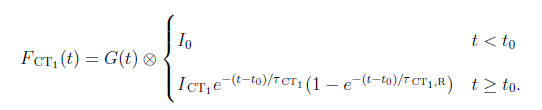
